# Libraries

##  Remove warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Import libraries

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import time
import random
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot   as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# Torch libraries
#
import torch
import torch.nn                     as nn
import torch.nn.functional          as F
from   torch.utils.data             import DataLoader
from   torch.utils.data             import Dataset


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# User libraries
#
from utils.PerformanceMetrics import RegressionEvaluation
from utils.EarlyStopping      import *
from utils.LRScheduler        import *

# Parameters

## CUDA

In [3]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())


2.2.0
12.1
True


In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print(f"[INFO] Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("[INFO] Using CPU")

[INFO] Using GPU: NVIDIA GeForce GTX 1660 SUPER


## Neural networks parameters

In [29]:
class Parameters():
    def __init__(self):
        self.description = 'DLinear model for time-series forecasting'
    
        # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
        # Neural network model parameters
        #
        # Input sequence length - look-back
        self.Lag         = 12
        # Prediction sequence length
        self.Horizon     =  4
        #
        self.individual  = False
        self.enc_in      = 1
        self.kernel_size = 25
        
        # Training parameters
        #
        # Number of epochs
        self.epochs        = 1000
        # Batch size
        self.batch_size    = 256
        # Number of workers in DataLoader
        self.num_workers   = 0
        # Define verbose
        self.verbose       = True
        # Learning rate
        self.learning_rate = 1e-4
        # Trained model path
        self.model_path    = 'models/DLinear.pth'
        
        # Data handling
        #
        # Filename
        self.filename              = './data/AirQuality.csv'
        # Target series name 
        self.targetSeries          = 'CO'
        # Training-set percentage
        self.TrainingSetPercentage = 0.8
        # Data Log-transformation
        self.Transformation        = True
        # Scaling {'Standard', 'MinMax', 'Robust'}
        self.Scaling               = 'Standard'

args = Parameters()

# Data handling

## Import data


In [6]:
# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( args.filename )

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

df.head(3)

[INFO] Data imported
[INFO] Time: 0.27 seconds


,Date,NO2,CO
0,2022-02-19 00:00:09,212.0,263.0
1,2022-02-19 00:00:25,209.0,261.0
2,2022-02-19 00:00:41,204.0,258.0


## Preprocess data

### Set index

In [7]:
# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64[ns]')

# Set index
#
df.set_index('Date', inplace=True)


# Keep only selected time-series
#
df = pd.DataFrame( df[ [ args.targetSeries ] ] )


df.head( 3 )

,CO
Date,
2022-02-19 00:00:09,263.0
2022-02-19 00:00:25,261.0
2022-02-19 00:00:41,258.0


### Split Training/Testing

In [8]:
df.shape

(406810, 1)

In [9]:
df.shape[0]

406810

In [10]:
idx = int( df.shape[0] * args.TrainingSetPercentage )

df_train = df[ :idx ].dropna()
df_test  = df[ idx: ].dropna()

In [11]:
df_train.tail(12)

,CO
Date,
2022-04-19 10:10:00,214.0
2022-04-19 10:10:16,213.0
2022-04-19 10:10:31,214.0
2022-04-19 10:10:47,216.0
2022-04-19 10:11:02,217.0
2022-04-19 10:11:18,219.0
2022-04-19 10:11:34,220.0
2022-04-19 10:11:50,220.0
2022-04-19 10:12:05,222.0


In [12]:
df_test.head(4)

,CO
Date,
2022-04-19 10:13:08,224.0
2022-04-19 10:13:23,223.0
2022-04-19 10:13:38,223.0
2022-04-19 10:13:53,223.0


### Visualization

(array([  0., 100., 200., 300., 400., 500.]),
 [Text(0, 0.0, '0'),
  Text(0, 100.0, '100'),
  Text(0, 200.0, '200'),
  Text(0, 300.0, '300'),
  Text(0, 400.0, '400'),
  Text(0, 500.0, '500')])

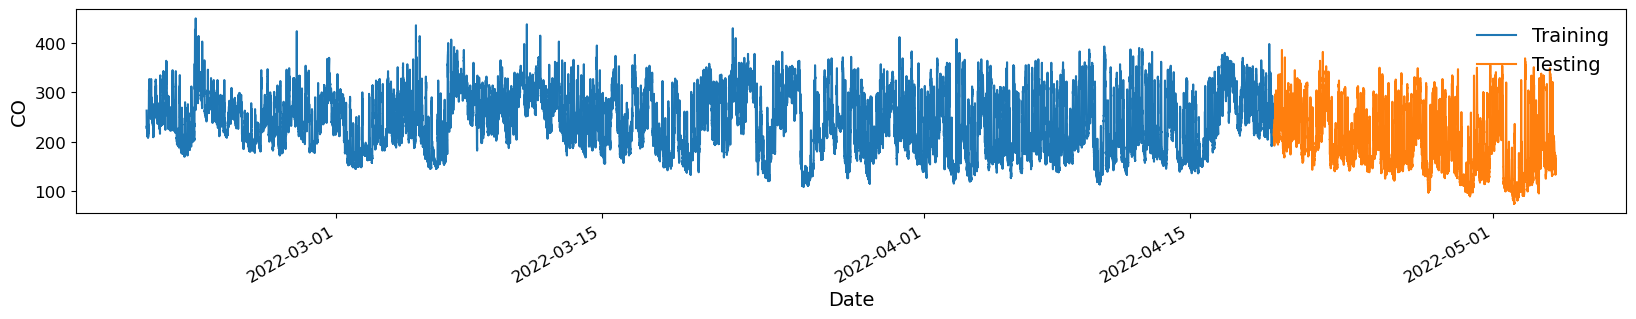

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 3))

df_train[ args.targetSeries ].plot(ax=ax, color='tab:blue' )
df_test[ args.targetSeries ].plot(ax=ax,  color='tab:orange')

plt.legend(['Training', 'Testing'], frameon = False, fontsize = 14)
plt.ylabel(args.targetSeries, size = 14)
plt.xlabel('Date', size = 14)
plt.xticks(size = 12)
plt.yticks(size = 12)

### Fixing Lag

In [14]:
df_test = pd.concat([df_train.iloc[-args.Lag:], df_test])
df_test.head(14)

,CO
Date,
2022-04-19 10:10:00,214.0
2022-04-19 10:10:16,213.0
2022-04-19 10:10:31,214.0
2022-04-19 10:10:47,216.0
2022-04-19 10:11:02,217.0
2022-04-19 10:11:18,219.0
2022-04-19 10:11:34,220.0
2022-04-19 10:11:50,220.0
2022-04-19 10:12:05,222.0


## Preprocessing

## Data Transformation

In [15]:
if (args.Transformation == True):
    
    print('[INFO] Data transformation applied')
    
    # 至少为1，保证对数变换后值都为非负数
    VALUE = np.ceil( max(abs( -df.min().min() ), 1.0) )
    # VALUE = np.ceil( max(abs( df.min().min() ), 1.0) )
    
    df_train = np.log( df_train + VALUE)
    df_test  = np.log( df_test  + VALUE)
    
else:
    print('[INFO] No data transformation applied.')  

[INFO] Data transformation applied


In [16]:
if (args.Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')
    
    for feature in df.columns:
        if (feature ==  args.targetSeries ): continue
        print('Feature: ', feature)        
        # Set scaler
        #
        scaler = MinMaxScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = MinMaxScaler()
    df_train[ args.targetSeries ] = scaler.fit_transform( df_train[  args.targetSeries  ].to_numpy().reshape(-1,1) )
    df_test[ args.targetSeries ]  = scaler.transform( df_test[  args.targetSeries  ].to_numpy().reshape(-1,1) )
            
elif (args.Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')
    
    for feature in df.columns:
        if (feature ==  args.targetSeries ): continue
        print('Feature: ', feature)        
        # Set scaler
        #
        scaler = RobustScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = RobustScaler()
    df_train[ args.targetSeries ] = scaler.fit_transform( df_train[  args.targetSeries  ].to_numpy().reshape(-1,1) )
    df_test[ args.targetSeries ]  = scaler.transform( df_test[  args.targetSeries  ].to_numpy().reshape(-1,1) )
        
elif (args.Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')

    for feature in df.columns:
        if (feature ==  args.targetSeries ): continue
        print('Feature: ', feature)
        # Set scaler
        #
        scaler = StandardScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = StandardScaler()

    df_train[ args.targetSeries ] = scaler.fit_transform( df_train[  args.targetSeries  ].to_numpy().reshape(-1,1) )
    df_test[ args.targetSeries ]  = scaler.transform( df_test[  args.targetSeries  ].to_numpy().reshape(-1,1) )          
       
else:
    print('[WARNING] Unknown data scaling. Standar scaling was selected')   
    
    for feature in df.columns:
        if (feature ==  args.targetSeries ): continue
        print('Feature: ', feature)
        # Set scaler
        #
        scaler = StandardScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = StandardScaler()

    df_train[ args.targetSeries ] = scaler.fit_transform( df_train[  args.targetSeries  ].to_numpy().reshape(-1,1) )
    df_test[ args.targetSeries ]  = scaler.transform( df_test[  args.targetSeries  ].to_numpy().reshape(-1,1) )  

[INFO] Scaling: Standard


## Create Training/Testing data

In [18]:
def create_dataset(df = None, Lag = 1, Horizon = 1, targetSeries = None, overlap = 1):
    # lag: number of past time steps to use as input
    # horizon: number of future time steps to predict
    # Step size when sliding the window
    
    if (targetSeries is None):
        targetSeries = df.columns[-1]
    
    dataX, dataY, dataDate = [], [], []
    
    for i in tqdm( range(0, df.shape[0] - Lag - Horizon + 1, overlap) ):
        
        dataX.append( df.to_numpy()[i:(i+Lag)] ) # dataX: [len(df) - lag - horizon + 2, lag, 1]        
        dataY.append( df[ targetSeries ].to_numpy()[i + Lag : i + Lag + Horizon] ) # dataY: [len(df) - lag - horizon + 2, horizon]
        dataDate.append( df.index[i + Lag : i + Lag + Horizon].tolist() ) # dataDate: [len(df) - lag - horizon + 2, horizon]
        
    return ( np.array(dataX), np.array(dataY), np.array(dataDate) )


In [19]:
trainX, trainY, _ = create_dataset(df           = df_train, 
                                   Lag          = args.Lag, 
                                   Horizon      = args.Horizon, 
                                   targetSeries = args.targetSeries,
                                   overlap      = 1,)

100%|██████████| 325433/325433 [00:14<00:00, 22614.18it/s]


In [ ]:
testX, testY, testDate = create_dataset(df           = df_test, 
                                        Lag          = args.Lag, 
                                        Horizon      = args.Horizon, 
                                        targetSeries = args.targetSeries,
                                        overlap      = 1,)

100%|██████████| 81359/81359 [00:03<00:00, 22803.65it/s]


In [21]:
# Last 10% of the training data will be used for validation
#
idx = int(0.9 * trainX.shape[0])
validX, validY = trainX[ idx: ], trainY[ idx: ]
trainX, trainY = trainX[ :idx ], trainY[ :idx ]

print('Training data shape:   ', trainX.shape, trainY.shape)
print('Validation data shape: ', validX.shape, validY.shape)
print('Testing data shape:    ', testX.shape,  testY.shape)

Training data shape:    (292889, 12, 1) (292889, 4)
Validation data shape:  (32544, 12, 1) (32544, 4)
Testing data shape:     (81359, 12, 1) (81359, 4)


In [22]:
# Reshaping
#
trainY = np.expand_dims(trainY, axis = -1)
validY = np.expand_dims(validY, axis = -1)
testY  = np.expand_dims(testY,  axis = -1)

In [23]:
class Data( Dataset ):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[ idx ], self.Y[ idx ]
    

    
# Create training and test dataloaders
#
train_ds = Data(trainX, trainY)
valid_ds = Data(validX, validY)
test_ds  = Data(testX,  testY)


# Prepare Data-Loaders
#
train_dl = DataLoader(train_ds, batch_size = args.batch_size, num_workers = args.num_workers)
valid_dl = DataLoader(valid_ds, batch_size = args.batch_size, num_workers = args.num_workers)
test_dl  = DataLoader(test_ds,  batch_size = args.batch_size, num_workers = args.num_workers)
#
print('[INFO] Data loaders were created')

[INFO] Data loaders were created


# Forecasting model: DLinear

In [25]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class Model(nn.Module):
    """
    DLinear
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.Lag  = configs.Lag
        self.Horizon = configs.Horizon

        # Decompsition Kernel Size
        kernel_size       = configs.kernel_size
        self.decompsition = series_decomp(kernel_size)
        self.individual   = configs.individual
        self.channels     = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend    = nn.ModuleList()
            self.Linear_Decoder  = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.Lag,self.Horizon))
                self.Linear_Seasonal[i].weight = nn.Parameter((1/self.Lag)*torch.ones([self.Horizon,self.Lag]))
                self.Linear_Trend.append(nn.Linear(self.Lag,self.Horizon))
                self.Linear_Trend[i].weight = nn.Parameter((1/self.Lag)*torch.ones([self.Horizon,self.Lag]))
                self.Linear_Decoder.append(nn.Linear(self.Lag,self.Horizon))
        else:
            self.Linear_Seasonal = nn.Linear(self.Lag,self.Horizon)
            self.Linear_Trend = nn.Linear(self.Lag,self.Horizon)
            self.Linear_Decoder = nn.Linear(self.Lag,self.Horizon)
            self.Linear_Seasonal.weight = nn.Parameter((1/self.Lag)*torch.ones([self.Horizon,self.Lag]))
            self.Linear_Trend.weight = nn.Parameter((1/self.Lag)*torch.ones([self.Horizon,self.Lag]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.Horizon],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.Horizon],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

## Setup model

In [26]:
# Initialize Neural Network
# 
model = Model( args )

model.to( device )


print( model )

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=12, out_features=4, bias=True)
  (Linear_Trend): Linear(in_features=12, out_features=4, bias=True)
  (Linear_Decoder): Linear(in_features=12, out_features=4, bias=True)
)


## Training parameters

In [27]:
# Specify loss function
#
criterion = nn.MSELoss()

# Specify loss function
#
optimizer = torch.optim.Adam(params = model.parameters(), 
                             lr     = args.learning_rate)




# Early stopping
#
early_stopping = EarlyStopping(patience  = 100,
                               min_delta = 1e-5)


# LR scheduler
#
scheduler = LRScheduler(optimizer = optimizer, 
                        patience  = 50, 
                        min_lr    = 1e-10, 
                        factor    = 0.5, 
                        verbose   = args.verbose)

## Training process

In [30]:
# Store training and validation loss
Loss = {
         'Train': [], 
         'Valid':  []
       }

# Set number at how many iteration the training process (results) will be provided
# 控制每隔多少个批次 (batch) 打印一次训练进度
batch_show = (train_dl.dataset.__len__() // args. batch_size // 5)

# Main loop - Training process
for epoch in range(1, args.epochs+1):

    # Start timer
    start = time.time()
    
    # Monitor training loss
    train_loss = 0.0
    valid_loss  = 0.0    
    
    ###################
    # Train the model #
    ###################
    batch_idx = 0
    for data, target in train_dl:
        
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # Forward pass: compute predicted outputs by passing inputs to the model
        if (device.type == 'cpu'):
            data   = torch.tensor(data,   dtype=torch.float32)
            target = torch.tensor(target, dtype=torch.float32)
        else:
            data   = torch.tensor(data,   dtype=torch.float32).cuda()
            target = torch.tensor(target, dtype=torch.float32).cuda()

        outputs = model( data )
        
        # Calculate the loss
        loss = criterion(outputs, target)
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # Perform a single optimization step (parameter update)
        optimizer.step()
        
        # Update running training loss
        train_loss += loss.item()*data.size(0)
               
        # Increase batch_idx
        batch_idx  += 1
        
        # Info
        if (args.verbose == True and batch_idx % batch_show == 0):
            print('> Epoch: {} [{:5.0f}/{} ({:.0f}%)]'.format(epoch, batch_idx * len(data), len(train_dl.dataset), 100. * batch_idx / len(train_dl)))        

    # Print avg training statistics 
    train_loss = train_loss / train_dl.dataset.X.shape[0]

    with torch.no_grad():
        for data, target in valid_dl:

            # Forward pass: compute predicted outputs by passing inputs to the model
            if (device.type == 'cpu'):
                data   = torch.tensor(data, dtype=torch.float32)
                target = torch.tensor(target, dtype=torch.float32)
            else:
                data   = torch.tensor(data, dtype=torch.float32).cuda()
                target = torch.tensor(target, dtype=torch.float32).cuda()

            outputs = model( data )
        
            # Calculate the loss
            loss = criterion(outputs, target)
                
            # update running training loss
            valid_loss += loss.item()*data.size(0)
              
    # Print avg training statistics 
    valid_loss = valid_loss / valid_dl.dataset.X.shape[0]

    # Stop timer
    stop  = time.time()
    
    # Show training results
    print('\n[INFO] Train Loss: {:.6f}\tValid Loss: {:.6f} \tTime: {:.2f}secs'.format(train_loss, valid_loss, stop-start), end=' ')

    # Update best model
    if (epoch == 1):
        Best_score = valid_loss
        torch.save(model.state_dict(), args.model_path)
        print('(Model saved)\n')
    else:
        if (Best_score > valid_loss):
            Best_score = valid_loss
            torch.save(model.state_dict(), args.model_path)
            print('(Model saved)\n')
        else:
            print('\n')
    
    # Store train/val loss
    Loss['Train'] += [ train_loss ]
    Loss['Valid'] += [ valid_loss ]

    # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    # Learning rate scheduler
    scheduler( valid_loss )
    
    # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    # Early Stopping
    if ( early_stopping( valid_loss ) ): break

> Epoch: 1 [58368/292889 (20%)]
> Epoch: 1 [116736/292889 (40%)]
> Epoch: 1 [175104/292889 (60%)]
> Epoch: 1 [233472/292889 (80%)]
> Epoch: 1 [291840/292889 (100%)]

[INFO] Train Loss: 0.008333	Valid Loss: 0.006414 	Time: 5.58secs (Model saved)

> Epoch: 2 [58368/292889 (20%)]
> Epoch: 2 [116736/292889 (40%)]
> Epoch: 2 [175104/292889 (60%)]
> Epoch: 2 [233472/292889 (80%)]
> Epoch: 2 [291840/292889 (100%)]

[INFO] Train Loss: 0.005690	Valid Loss: 0.004381 	Time: 5.01secs (Model saved)

> Epoch: 3 [58368/292889 (20%)]
> Epoch: 3 [116736/292889 (40%)]
> Epoch: 3 [175104/292889 (60%)]
> Epoch: 3 [233472/292889 (80%)]
> Epoch: 3 [291840/292889 (100%)]

[INFO] Train Loss: 0.004132	Valid Loss: 0.003158 	Time: 4.96secs (Model saved)

> Epoch: 4 [58368/292889 (20%)]
> Epoch: 4 [116736/292889 (40%)]
> Epoch: 4 [175104/292889 (60%)]
> Epoch: 4 [233472/292889 (80%)]
> Epoch: 4 [291840/292889 (100%)]

[INFO] Train Loss: 0.003262	Valid Loss: 0.002480 	Time: 5.04secs (Model saved)

> Epoch: 5 [5836

## Load optimized model

In [31]:
# Load best model
model.load_state_dict( torch.load( args.model_path ) )
model.eval()
print('[INFO] Model loaded')

[INFO] Model loaded


## Evaluation

### Get predictions

In [32]:
pred = None
with torch.no_grad():
    for data, target in tqdm( test_dl ):

        data   = torch.tensor(data,   dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)

        if (pred is None):
            pred = model( data ).numpy()
        else:
            pred = np.concatenate([pred, model( data ).numpy()])

  0%|          | 0/318 [00:03<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
# Reshaping...
testY = testY.squeeze(-1)
pred  = pred.squeeze(-1)

### Apply inverse scaling/transformation

In [ ]:
# Apply inverse scaling
for i in range( args.Horizon ):
    testY[:,  i] = scaler.inverse_transform( testY[:,  i].reshape(-1,1) ).squeeze(-1)
    pred[:, i]   = scaler.inverse_transform( pred[:, i].reshape(-1,1) ).squeeze(-1)

# Apply inverse transformation   
if (args.Transformation == True):
    testY = np.exp( testY ) - VALUE
    pred  = np.exp( pred )  - VALUE

### Calculate Performance on Testing set - Prediction visualization


In [ ]:
print('[INFO] Feature: ', args.targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( args.Horizon ):

    Prices = pd.DataFrame([])        

    Prices[ args.targetSeries ] = testY[:,i]
    Prices[ 'Prediction'      ] = pred[:,i]


    # Evaluation
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

    # Store results
    Performance_Foresting_Model['RMSE']    += [ RMSE    ]
    Performance_Foresting_Model['MAE']     += [ MAE     ]
    Performance_Foresting_Model['SMAPE']   += [ SMAPE   ]
    Performance_Foresting_Model['R2']      += [ R2      ]

    # Present results
    print('Horizon: %2i MAE %5.2f RMSE %5.2f SMAPE: %5.2f R2: %.2f' % (i+1, MAE, RMSE, SMAPE, R2) )

### Residual examination

In [ ]:
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf

for i in range( args.Horizon ):

    # Get actual values and predicted
    Prices = pd.DataFrame([])        

    Prices[ args.targetSeries ] = testY[:,i]
    Prices[ 'Prediction'      ] = pred[:,i]
                        
    # Calculate the residuals
    res = (Prices[ args.targetSeries ] - Prices['Prediction']).to_numpy()
    
    # === Visualization ===
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 2) )

    # Plot residual histogram
    ax[0].hist(res, bins = 50)    
    
    # Plot AutoCorrelation plot
    plot_acf( res, ax=ax[1] )       
    ax[1].set_ylim([-1.05, 1.05])

## Examples

In [ ]:
# # Apply inverse scaling on trainX
# for i in range( trainX.shape[1] ):
#     testX[:,  i, 0] = scaler.inverse_transform( testX[:, i, 0].reshape(-1,1) ).squeeze(-1)


# # Apply inverse transformation   
# if (Transformation == True):
#     testX = np.exp( testX ) - VALUE

In [ ]:
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (20, 15) )

# Select random cases
RandomInstances = [random.randint(1, testY.shape[0]) for i in range(0, 9)]

for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    plt.grid()
  # plot_scatter(range(0, Lag), testX[i,:,0], color='b')
    plt.plot(testDate[i], testY[i], color='g', marker = 'o', linewidth = 2)
    plt.plot(testDate[i], pred[i],  color='r', marker = 'o', linewidth = 2)

    plt.legend(['Actual values', 'Prediction'], frameon = False, fontsize = 12)
    plt.ylim([np.min(testY[i]) - 10, np.max(testY[i]) + 10])
    plt.xticks(rotation=45)
plt.show()